<h1><center>scikit-learn and fairness, tools and challenges</center></h1>
<h3><center>Adrin Jalali</center></h3>
<h4><center>@adrinjalali, Hugging Face</center></h3>
<h4><center>September 2022</center></h3>


## Me
- PhD in interpretable methods for cancer diagnostics
- ML consulting
- Worked in an algorithmic privacy and fairness team
- Open source
    - `scikit-learn`
    - `fairlearn`
- Now at HuggingFace (and also do `skops`)

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml
from bokeh.plotting import figure, show, output_notebook
from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.base import clone
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
import numpy as np
from sklearn import set_config
set_config(display='diagram')
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

output_notebook()

Loading BokehJS ...

## Challenges
- Fairness is sociotechnical
  - We're biased, our data is biased
  - Structural challenges in the society
    - Systematic and institutional racism, sexism, etc
- What does it mean to be fair?
  - Fairness is not a well-defined term / concept
  - Many different metrics
    - Their consequences
    - How legislation and certain ethical concerns translate into them
    - Impossibility theorem
  - Individual vs Group fairness
- Fairness vs. Model Performance
  - Convincing stakeholders to accept the loss

## Challenges (cntd.)
- Tensions with policies and legislation
  - GDPR protects personal information:
    - racial or ethnic origin; political opinions; religious or philosophical beliefs; etc.
  - Excluding these attributes doesn't make models _fair_.
  - Upcoming EU AI Act: regulating crucial and high risk systems
- Skills and tools gap among practitioners
  - Include these issues in curiculums
  - Tools which can be used with ease and work with the existing workflows and pipelines -> this talk

## Overview
- Example classification
- Fairness related metrics
- Try to "repair" the issue
- Some existing tools 
- scikit-learn API requirements and limitations

## UCI Adult Dataset
For this example we use the UCI adult dataset where the objective is to predict whether a person makes more or less than $50,000 a year.

Note: This data includes a _sex_ attribute and not _gender_, and sees the attribute as binary, all of which are problematic!

In [2]:
data = fetch_openml(data_id=1590, as_frame=True)
X, y = data.data, data.target
y = (y == ">50K").astype(int)
X_train, X_test, y_train, y_test, data_train, data_test = train_test_split(
    X, y, data.data
)
X_train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
35805,21.0,Private,216181.0,Some-college,10.0,Never-married,Sales,Own-child,White,Male,0.0,0.0,35.0,United-States
3413,44.0,NaN,177461.0,Some-college,10.0,Divorced,NaN,Unmarried,Amer-Indian-Eskimo,Male,0.0,0.0,50.0,United-States
20050,27.0,Private,187392.0,HS-grad,9.0,Never-married,Other-service,Not-in-family,White,Female,0.0,0.0,40.0,United-States
26603,35.0,Private,52187.0,Some-college,10.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States
36726,24.0,Private,153583.0,Some-college,10.0,Never-married,Sales,Own-child,White,Female,0.0,0.0,40.0,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,31.0,Private,153078.0,Assoc-acdm,12.0,Never-married,Craft-repair,Own-child,Other,Male,0.0,0.0,50.0,United-States
45891,60.0,Private,399387.0,7th-8th,4.0,Separated,Priv-house-serv,Unmarried,Black,Female,0.0,0.0,15.0,United-States
42613,55.0,Private,175942.0,Doctorate,16.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,1977.0,55.0,NaN
43567,29.0,Self-emp-not-inc,85572.0,11th,7.0,Married-civ-spouse,Other-service,Wife,White,Female,0.0,0.0,5.0,United-States


## Bias in the data

Here we measure the _selection_rate_ which calculates the fraction of predicted labels in each group matching the "good" outcome. 

In [3]:
def plot_selection_rate(sensitive_attr, title, **kwargs):
    from bokeh.io import show
    from bokeh.models import ColumnDataSource, FactorRange
    from bokeh.plotting import figure

    data = []
    for key, value in kwargs.items():
        selection_rates = MetricFrame(
            metrics=selection_rate,
            y_true=value,
            y_pred=value,
            sensitive_features=sensitive_attr,
        )

        cats = list(selection_rates.by_group.index)
        data.append([selection_rates.by_group[s] for s in cats])

    sub_cats = list(kwargs.keys())

    x = [(cat, sub_cat) for cat in cats for sub_cat in sub_cats]
    if len(kwargs.keys()) > 1:
        counts = sum(zip(*data), ())  # like an hstack
    else:
        counts=data[0]
    source = ColumnDataSource(data=dict(x=x, counts=counts))
    p = figure(
        x_range=FactorRange(*x),
        plot_height=480,
        title=title,
        toolbar_location=None,
        tools="",
    )

    p.vbar(x="x", top="counts", width=0.9, source=source)

    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None

    # p.vbar(x=xs, top=ys, width=0.9)
    # p.vbar(x=xs, top=[.2, .5], width=0.9)
    # p.y_range.start = 0
    show(p)

In [4]:
plot_selection_rate(
    dataset=y_test, sensitive_attr=data_test["sex"], title="Fraction earning over $50,000"
)

## Train a classifier
Then we can train a classiffier on the data and measure how accurate it is on each subgroup.

In [5]:
preprocessor = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=255),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

model = make_pipeline(
    preprocessor,
    HistGradientBoostingClassifier(
        max_iter=10_000,
        early_stopping=True,
        random_state=0,
    ),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=255),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f370751e160>)])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                max_iter=10000,
                                                random_state=0))])

In [6]:
print("roc_auc score:", roc_auc_score(y_test, model.predict(X_test)))
sr_unmitigated = MetricFrame(
    metrics={"selection_rate": selection_rate, "roc_auc": roc_auc_score},
    y_true=y_test,
    y_pred=model.predict(X_test),
    sensitive_features=data_test["sex"],
)
print(f"overall:\n{sr_unmitigated.overall}")
print(f"by group:\n{sr_unmitigated.by_group}")

roc_auc score: 0.8030819839940239
overall:
selection_rate    0.204078
roc_auc           0.803082
dtype: float64
by group:
        selection_rate   roc_auc
sex                             
Female        0.081226  0.797059
Male          0.266453  0.794141


_selection_rate_ on the output of the classifier

In [7]:
plot_selection_rate(
    dataset=y_test,
    classifier=model.predict(X_test),
    sensitive_attr=data_test["sex"],
    title="Fraction earning over $50,000",
)

## Demographic Parity Ratio
The demographic parity ratio is defined as the ratio between the smallest and the largest group-level selection rate, $E[h(X)|A=a]$, across all values a of the sensitive feature(s). The demographic parity ratio of 1 means that all groups have the same selection rate.

In [8]:
from fairlearn.metrics import demographic_parity_ratio

demographic_parity_ratio(
    y_true=y_test, y_pred=model.predict(X_test), sensitive_features=data_test["sex"]
)

0.30484095916740894

## "repairing" our classifier

We use the `ExponentiatedGradient`[2] with a `DemographicParity` constraint from `fairlearn`.

[2] https://arxiv.org/abs/1803.02453

In [23]:
# Note: this fails (expected)

constraint = DemographicParity()
clf = clone(model)
mitigator = ExponentiatedGradient(clf, constraint)
mitigator.fit(X_train, y_train, sensitive_features=data_train["sex"])
sr_mitigated = MetricFrame(
    metrics={"selection_rate": selection_rate, "roc_auc": roc_auc_score},
    y_true=y_test,
    y_pred=mitigator.predict(X_test),
    sensitive_features=data_test["sex"],
)

ValueError: Pipeline.fit does not accept the sample_weight parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.

In [10]:
X_train_t = preprocessor.fit_transform(X_train, y_train)
X_test_t = preprocessor.transform(X_test)

constraint = DemographicParity()
clf = HistGradientBoostingClassifier(
    max_iter=10_000,
    early_stopping=True,
    random_state=0,
)
mitigator = ExponentiatedGradient(clf, constraint)
mitigator.fit(X_train_t, y_train, sensitive_features=data_train["sex"])
sr_mitigated = MetricFrame(
    metrics={"selection_rate": selection_rate, "roc_auc": roc_auc_score},
    y_true=y_test,
    y_pred=mitigator.predict(X_test_t),
    sensitive_features=data_test["sex"],
)
print(f"overall:\n{sr_mitigated.overall}")
print(sr_mitigated.by_group)

overall:
selection_rate    0.178773
roc_auc           0.755201
dtype: float64
        selection_rate   roc_auc
sex                             
Female        0.164640  0.865607
Male          0.185949  0.741151


In [11]:
plot_selection_rate(
    dataset=y_test,
    classifier=model.predict(X_test),
    mitigated=mitigator.predict(X_test_t),
    sensitive_attr=data_test["sex"],
    title="Fraction earning over $50,000",
)

## Demographic Parity Ratio

In [12]:
demographic_parity_ratio(
    y_true=y_test, y_pred=mitigator.predict(X_test_t), sensitive_features=data_test["sex"]
)

0.8749449409921536

Things which didn't work:

- Hyperparameter optimization
- Preprocessing (one hot encoding, etc)
- Pipelines

## (notes from) scikit-learn API
- transformers: `.fit()`, `.transform()`
- predictors: `.fit()`, `.predict()`
- scorers
- Meta-estimators
    - `Pipeline`: steps
    - `GridSearchCV`

- Sample parameters:
    - Meta-estimators: `step_name__param_name` to `.fit()`


## Injecting fairness related methods in a scikit-learn pipeline
- Metrics
- Transformers
- Classifier/Regressor
- Postprocessor
  - A meta-estimator encapsulating another estimator does the job

## Pipelines
- It's too easy to have data leackage if there's some preprocessing done outside a pipeline or before a test-train split is done.
  - One hot encoder, scalers (mean and variance estimations), etc
  
- Put everything in a pipeline, then optimize your hyperparameters

In [13]:
numeric_features = ["age", "fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["embarked", "sex", "pclass"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['embarked', 'sex',
                                                   'pclass'])])),
                ('classifier', LogisticRegression())])

## Multimetric grid search
Use multiple metrics in a grid search, and plot them against the hyper parameters.

In [14]:
# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``

param_grid = {"max_depth": [2, 4, 6, 7, 8, 9, 10, 11, 15, 20, 30]}
X_gs = pd.get_dummies(X)
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring=scoring,
    refit="AUC",
    return_train_score=True,
    n_jobs=6,
)
gs.fit(X_gs, y)
gs.best_estimator_

DecisionTreeClassifier(max_depth=9, random_state=42)

In [15]:
def plot_results(results):
    plt.figure(figsize=(13, 13))
    plt.title(
        "GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16
    )

    plt.xlabel("max_depth")
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xlim(0, 30)
    ax.set_ylim(0.73, 1)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results["param_max_depth"].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ["g", "k"]):
        for sample, style in (("train", "--"), ("test", "-")):
            sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
            sample_score_std = results["std_%s_%s" % (sample, scorer)]
            ax.fill_between(
                X_axis,
                sample_score_mean - sample_score_std,
                sample_score_mean + sample_score_std,
                alpha=0.1 if sample == "test" else 0,
                color=color,
            )
            ax.plot(
                X_axis,
                sample_score_mean,
                style,
                color=color,
                alpha=1 if sample == "test" else 0.7,
                label="%s (%s)" % (scorer, sample),
            )

        best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
        best_score = results["mean_test_%s" % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot(
            [
                X_axis[best_index],
            ]
            * 2,
            [0, best_score],
            linestyle="-.",
            color=color,
            marker="x",
            markeredgewidth=3,
            ms=8,
        )

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

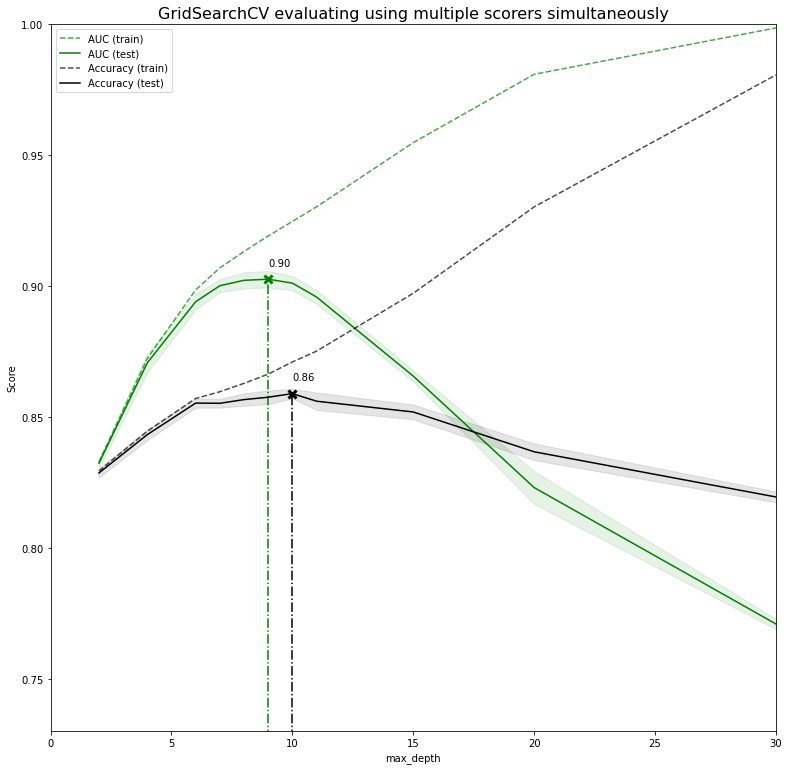

In [16]:
from matplotlib import pyplot as plt
plot_results(gs.cv_results_)

### Callable `refit`

This example balances model complexity and cross-validated score by
finding a decent score within 1 standard deviation of the best AUC score while minimising model complexity [1].

[1] Hastie, T., Tibshirani, R.,, Friedman, J. (2001). Model Assessment and
Selection. The Elements of Statistical Learning (pp. 219-260). New York,
NY, USA: Springer New York Inc..

In [17]:
def lower_bound(cv_results):
    """
    Calculate the lower bound within 1 standard deviation
    of the best `mean_test_AUC`.
    """
    best_score_idx = np.argmax(cv_results["mean_test_AUC"])

    return (
        cv_results["mean_test_AUC"][best_score_idx]
        - cv_results["std_test_AUC"][best_score_idx]
    )


def best_low_complexity(cv_results):
    """
    Balance model complexity with cross-validated score.
    """
    threshold = lower_bound(cv_results)
    candidate_idx = np.flatnonzero(cv_results["mean_test_AUC"] >= threshold)
    best_idx = candidate_idx[cv_results["param_max_depth"][candidate_idx].argmin()]
    return best_idx

In [18]:
gs_refit = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring=scoring,
    refit=best_low_complexity,
    return_train_score=True,
    n_jobs=6,
) 
gs_refit.fit(X_gs, y)
gs_refit.best_estimator_

DecisionTreeClassifier(max_depth=7, random_state=42)

### Choosing a point on a pareto curve
The above API would ideally enable us to choose a model based on the pareto frontier of error

In [19]:
def plot_pareto_curve():
    plt.xlabel("Error")
    plt.ylabel("Disparity")
    plt.title("Pareto Frontier")
    ax = plt.gca()
    plt.gcf().set_size_inches(10, 7)
    scores = [0.50, 0.53, 0.60, 0.65, 0.70, 0.80, 0.85, 0.88, 0.90]
    fairness = [0.080, 0.050, 0.035, 0.025, 0.020, 0.016, 0.014, 0.012, 0.011]
    ax.plot(scores, fairness)
    plt.plot([0.5, 0.9], [0.03, 0.03], color="orange")
    plt.show()

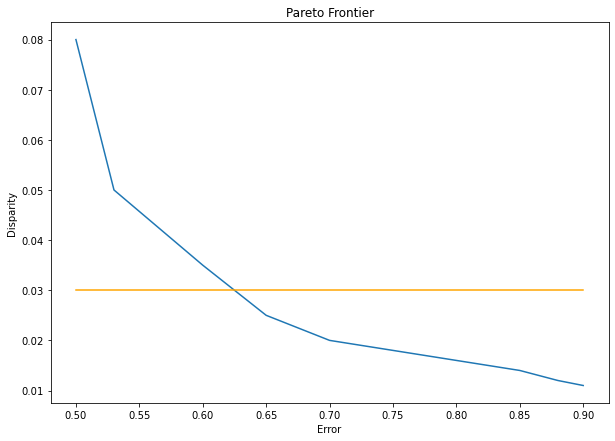

In [20]:
plot_pareto_curve()

In [21]:
def best_low_complexity(cv_results):
    threshold = lower_bound(cv_results)
    candidate_idx = np.flatnonzero(cv_results["mean_test_AUC"] >= threshold)
    best_idx = candidate_idx[cv_results["param_max_depth"][candidate_idx].argmin()]
    return best_idx

In [22]:
def best_model_selector(cv_results):
    threshold = lower_bound(cv_results)
    candidate_idx = np.flatnonzero(
        np.logical_and(
            cv_results["mean_test_AUC"] >= threshold,
            cv_results["mean_test_fairness_violation"] < 0.03,
        )
    )
    best_idx = candidate_idx[cv_results["param_max_depth"][candidate_idx].argmin()]
    return best_idx

## Tools
### Fairlearn
- fairlearn.metrics
- fairlearn.postprocessing
- fairlearn.reductions
- fairlearn.datasets

Defaulting on sklearn compatibility, but there are many challenges ahead.

## Tools
### AIF360

- aif360.algorithms (preprocessing, inprocessing, postprocessing)
- aif360.datasets
- aif360.metrics
- aif360.sklearn
  
Datasets are a key, and the sklearn submodule expects a pandas DataFrame with sensitive attributes on the index, so not really sklearn compatible.

## scikit-learn API enhancments
- Metadata Routing
- Feature Names
- Resamplers

## Metadata Routing

This requires passing sensitive attributes to the scorer!
- Sample aligned properties -> [SLEP006](https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep006/proposal.html), [Meta-issue#22893](https://github.com/scikit-learn/scikit-learn/issues/22893)

``` python
equalized_odds_scorer = make_scorer(equalized_odds_ratio).set_score_request(
    sensitive_attribute="gender"
)
estimator = make_pipeline(
    DisparateImpactRemover().set_fit_request(sensitive_attribute="gender"),
    SVC().set_fit_request(sample_weight=True),
)
gs = GridSearchCV(
    estimator,
    param_grid=param_grid,
    scoring=["roc_auc", equalized_odds_scorer],
    refit=best_model_selector,
)
gs.fit(X, y, sample_weight=sample_weight, gender=data["gender"])
```

## Feature Names

Including sensitive attributes in the data and taking them into account

Imagine such a pipeline:
``` python
make_pipeline(ColumnTransformer(...), XTransformer(...), ..., XClassifier())
```

It'd be nice to be able to pass the names of the features to estimators and inspect those feature names within a pipeline:

``` python
XTransformer(..., sensitive_attributes=["x", "y", "z"])
```

## Feature Names

This requires feature names to be propagated in a pipeline. 
- `pandas.DataFrame` and `xarray.DataArray` can include that info
- [PR#23734](https://github.com/scikit-learn/scikit-learn/pull/23734), [SLEP007](https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep007/proposal.html), [SLEP018](https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep018/proposal.html)

You can then also inspect models using `.feature_names_in_` and `.get_feature_names_out()`.

Calling a transformer would look like:

``` python
df_transformed = (
    transformer.set_output(transform="pandas")
    .transform(df, y)
)
```

## Resamplers and reweighing
- Currently sklearn doesn't really support resampling in a `pipeline`, either through `sample_weight` or by changing the `X`
- Discussions around resamplers: [SLEP005](https://github.com/scikit-learn/enhancement_proposals/pull/15/files)
- Example usage:

``` python
est = make_pipeline(
    StandardScaler(),
    ResampledTrainer(Birch(), make_pipeline(SelectKBest(), SVC()))
)
```

We can already handle most resampling issues via meta-estimators.

## Concluding Remarks
- More and more groups/companies are releasing their tools
- Our toolset were not designed having fairness related requirements in mind
- There's been significant efforts in the community, and I'm very excited about the upcoming releases!

<h1><center>♡ Thank YOU ♡</center></h1>
<h1><center>🤔 Questions! 🧐</center></h1>